In [ ]:
# combined nyc taxi data from March and April 2024
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
taxi_mar = pd.read_parquet('yellow_tripdata_2024-03.parquet')
taxi_apr = pd.read_parquet('yellow_tripdata_2024-04.parquet')
taxi_combined = pd.concat([taxi_mar, taxi_apr], ignore_index=True)
taxi_combined.to_csv('yellow_tripdata.csv', index=False)

In [1]:
import mysql.connector
from dotenv import load_dotenv
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load environment variables
load_dotenv()   
# Connect to MySQL database
db_connection = mysql.connector.connect(
    host=os.getenv('DB_HOST'),
    user=os.getenv('DB_USER'),
    password=os.getenv('DB_PASSWORD'),
    database=os.getenv('DB_NAME')
)



/var/folders/jc/zlyx5cfj47b4kf9kgt678kkc0000gn/T/ipykernel_11026/1363127005.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pickup_zone_counts = pd.read_sql(query, db_connection)


count       252.000000
mean      23198.392857
std       55866.174238
min           1.000000
25%         129.250000
50%         391.500000
75%        2455.000000
max      290454.000000
Name: count, dtype: float64


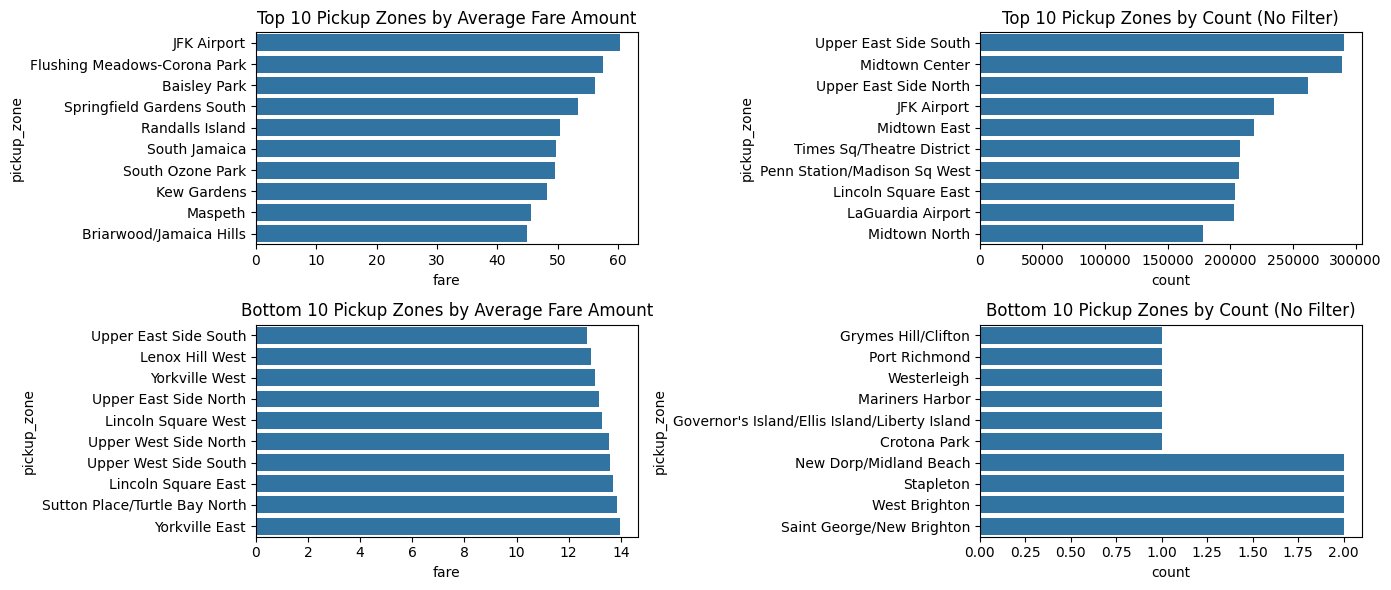

In [64]:
# table of top pick up zones by average fare amount
query = """
SELECT pickup_zone, AVG(fare_amount) as fare, COUNT(*) as count 
FROM nyc_taxi.yellow_taxi_clean as Y
GROUP BY pickup_zone;
"""
pickup_zone_counts = pd.read_sql(query, db_connection)
pickup_zone_counts = pickup_zone_counts.sort_values(by='count', ascending=False)

print(pickup_zone_counts['count'].describe())
pickup_zone_counts_no_outliers = pickup_zone_counts[pickup_zone_counts['count'] > 100]
pickup_zone_counts_no_filter = pickup_zone_counts.sort_values(by ='count', ascending=False).head(10)
pickup_zone_counts_no_filter_bottom = pickup_zone_counts.sort_values(by ='count', ascending=True).head(10)

pickup_zone_counts_top = pickup_zone_counts_no_outliers.sort_values(by='fare', ascending=False).head(10)
pickup_zone_counts_bottom = pickup_zone_counts_no_outliers.sort_values(by='fare', ascending=True).head(10)
fig, axes = plt.subplots(2, 2, figsize=(14, 6))

sns.barplot(data=pickup_zone_counts_top, x='fare', y='pickup_zone', ax=axes[0, 0])
axes[0,0].set_title('Top 10 Pickup Zones by Average Fare Amount')
sns.barplot(data=pickup_zone_counts_bottom, x='fare', y='pickup_zone', ax=axes[1, 0])
axes[1,0].set_title('Bottom 10 Pickup Zones by Average Fare Amount')

sns.barplot(data=pickup_zone_counts_no_filter, x='count', y='pickup_zone', ax=axes[0, 1])
axes[0, 1].set_title('Top 10 Pickup Zones by Count (No Filter)')
sns.barplot(data=pickup_zone_counts_no_filter_bottom, x='count', y='pickup_zone', ax=axes[1, 1])
axes[1, 1].set_title('Bottom 10 Pickup Zones by Count (No Filter)')
plt.tight_layout()
plt.show()




/var/folders/jc/zlyx5cfj47b4kf9kgt678kkc0000gn/T/ipykernel_11026/3108889321.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pickup_borough_fare = pd.read_sql(query, db_connection)


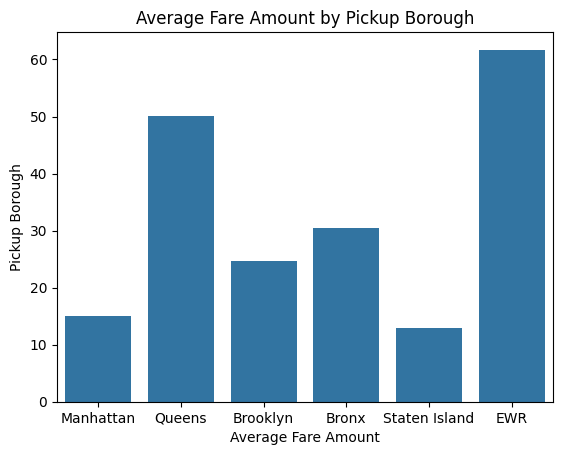

In [33]:
# pick up borough by average fare amount
query = """
SELECT pickup_borough, AVG(fare_amount) as Average, COUNT(fare_amount) as trip_count FROM nyc_taxi.yellow_taxi_clean
GROUP BY pickup_borough
ORDER BY AVG(fare_amount) DESC;
"""
pickup_borough_fare = pd.read_sql(query, db_connection)
pickup_borough_fare = pickup_borough_fare.sort_values(by='trip_count', ascending=False)
sns.barplot(data=pickup_borough_fare, x='pickup_borough', y='Average')
plt.title('Average Fare Amount by Pickup Borough')
plt.xlabel('Average Fare Amount')
plt.ylabel('Pickup Borough')
plt.show()

In [31]:
# weekday vs weekend fare amounts
import scipy.stats as stats
query = """
SELECT day_case, COUNT(*) AS Trip_count, AVG(fare_amount),STD(fare_amount) as std, AVG(Trip_duration) FROM (SELECT *, CASE WHEN DAYOFWEEK(pickup_date) BETWEEN  2 and 6 THEN 'Weekday' ELSE 'Weekend' END AS day_case FROM nyc_taxi.yellow_taxi_clean) AS mini
GROUP BY day_case;
"""
day_counts = pd.read_sql(query, db_connection)
print(day_counts)
meanWeekday, stdWeekday, countWeekday = day_counts['AVG(fare_amount)'][0], day_counts['std'][0], day_counts['Trip_count'][0]
meanWeekend, stdWeekend, countWeekend = day_counts['AVG(fare_amount)'][1], day_counts['std'][1], day_counts['Trip_count'][1]
print(f"Weekday: mean={meanWeekday}, std={stdWeekday}, count={countWeekday}")
print(f"Weekend: mean={meanWeekend}, std={stdWeekend}, count={countWeekend}")

z = (meanWeekday - meanWeekend) / ((stdWeekday**2/countWeekday + stdWeekend**2/countWeekend)**0.5)
print(f"Z-score for difference in average fare amounts between weekdays and weekends: {z}")
print(f"p-value for difference in average fare amounts between weekdays and weekends: {2 * (1 - stats.norm.cdf(abs(z)))}")

/var/folders/jc/zlyx5cfj47b4kf9kgt678kkc0000gn/T/ipykernel_11026/2979252126.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  day_counts = pd.read_sql(query, db_connection)


  day_case  Trip_count  AVG(fare_amount)        std  AVG(Trip_duration)
0  Weekday     4188530         18.068769  14.683820             14.9780
1  Weekend     1657465         18.245725  15.537078             14.1909
Weekday: mean=18.068769, std=14.683820392402533, count=4188530
Weekend: mean=18.245725, std=15.53707768190699, count=1657465
Z-score for difference in average fare amounts between weekdays and weekends: -12.60369216933442
p-value for difference in average fare amounts between weekdays and weekends: 0.0


In [ ]:
# Rainy vs Non-Rainy Days
query = """
SELECT rain_case, COUNT(*) as Trip_count, AVG(fare_amount), AVG(Trip_duration) FROM (SELECT *, CASE WHEN precip > 0 THEN 'Rainy' ELSE 'Non-rainy' END AS rain_case FROM nyc_taxi.yellow_taxi_clean) AS mini
GROUP BY rain_case;
"""
rain_counts = pd.read_sql(query, db_connection)
print(rain_counts)
meanRainy, stdRainy, countRainy = rain_counts['AVG(fare_amount)'][0], rain_counts['AVG(Trip_duration)'][0], rain_counts['Trip_count'][0]
meanNonRainy, stdNonRainy, countNonRainy = rain_counts['AVG(fare_amount)'][1], rain_counts['AVG(Trip_duration)'][1], rain_counts['Trip_count'][1]
print(f"Rainy: mean={meanRainy}, std={stdRainy}, count={countRainy}")
print(f"Non-Rainy: mean={meanNonRainy}, std={stdNonRainy}, count={countNonRainy}")
z = (meanRainy - meanNonRainy) / ((stdRainy**2/countRainy + stdNonRainy**2/countNonRainy)**0.5)
print(f"Z-score for difference in average fare amounts between rainy and non-rainy days: {z}")
print(f"p-value for difference in average fare amounts between rainy and non-rainy days: {2 * (1 - stats.norm.cdf(abs(z)))}")


/var/folders/jc/zlyx5cfj47b4kf9kgt678kkc0000gn/T/ipykernel_11026/816286346.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  rain_counts = pd.read_sql(query, db_connection)


   rain_case  Trip_count  AVG(fare_amount)  AVG(Trip_duration)
0  Non-rainy     3116164         18.266656             14.7661
1      Rainy     2729831         17.950319             14.7420


/var/folders/jc/zlyx5cfj47b4kf9kgt678kkc0000gn/T/ipykernel_11026/2697241503.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  trip_duration_fare = pd.read_sql(query, db_connection)


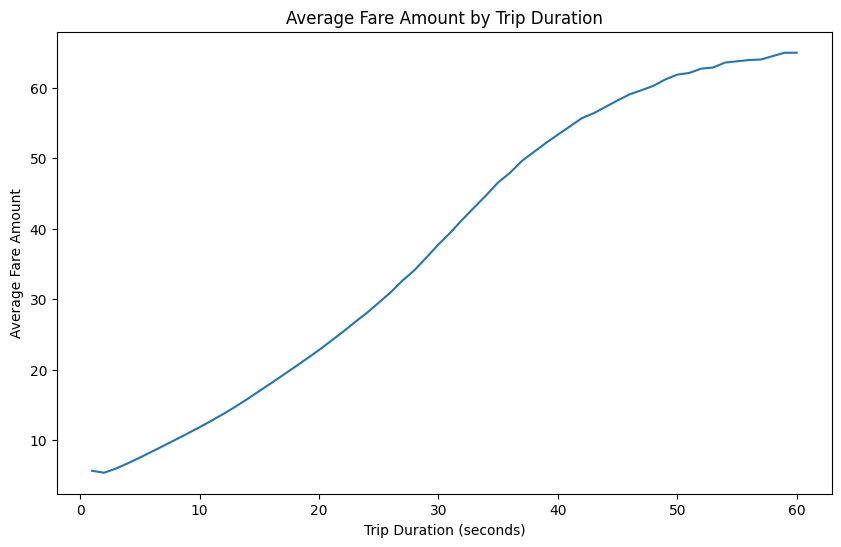

In [ ]:
query = """
SELECT Trip_duration, AVG(fare_amount) FROM nyc_taxi.yellow_taxi_clean
GROUP BY Trip_duration
ORDER BY Trip_duration;
"""
trip_duration_fare = pd.read_sql(query, db_connection)
trip_duration_fare = trip_duration_fare.sort_values(by='Trip_duration')
plt.figure(figsize=(10, 6))
sns.lineplot(data=trip_duration_fare, x='Trip_duration', y='AVG(fare_amount)')
plt.title('Average Fare Amount by Trip Duration')
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Average Fare Amount')
plt.show()


/var/folders/jc/zlyx5cfj47b4kf9kgt678kkc0000gn/T/ipykernel_11026/3937893447.py:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  weekday_weekend_counts = pd.read_sql(query, db_connection)


  pickup_borough  Trip_count  Trip_count_Weekday  Trip_count_Weekend  \
0          Bronx        8627                6423                2204   
1       Brooklyn       38662               29243                9419   
2            EWR          27                  19                   8   
3      Manhattan     5303548             3800353             1503195   
4         Queens      495066              352446              142620   
5  Staten Island          65                  46                  19   

   Avg_fare_Weekday  Avg_fare_Weekend  Avg_duration_Weekday  \
0         31.599721         27.388339               34.7584   
1         24.696103         24.743190               27.2574   
2         63.089474         58.437500               25.7368   
3         15.062328         15.082399               13.2335   
4         49.688424         51.014674               32.4084   
5         12.551957         13.851579               17.8043   

   Avg_duration_Weekend  
0               25.8471  
1

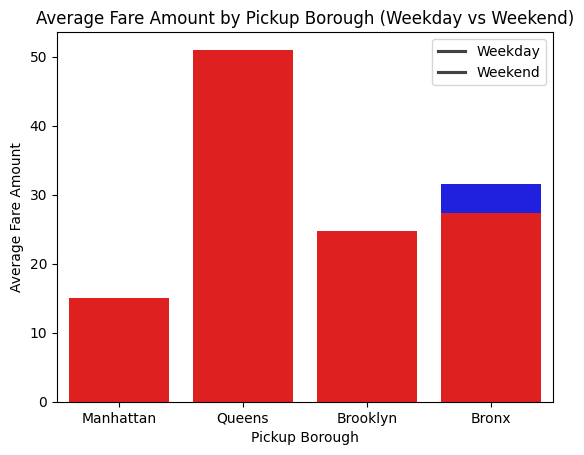

In [47]:
#weekday vs weekend by borough
query = """
SELECT 
  pickup_borough,
  
  -- Total trip counts
  COUNT(*) AS Trip_count,
  -- Trip counts
  COUNT(CASE WHEN DAYOFWEEK(pickup_date) BETWEEN 2 AND 6 THEN 1 END) AS Trip_count_Weekday,
  COUNT(CASE WHEN DAYOFWEEK(pickup_date) NOT BETWEEN 2 AND 6 THEN 1 END) AS Trip_count_Weekend,
  
  -- Average fare amounts
  AVG(CASE WHEN DAYOFWEEK(pickup_date) BETWEEN 2 AND 6 THEN fare_amount END) AS Avg_fare_Weekday,
  AVG(CASE WHEN DAYOFWEEK(pickup_date) NOT BETWEEN 2 AND 6 THEN fare_amount END) AS Avg_fare_Weekend,
  
  -- Average trip duration
  AVG(CASE WHEN DAYOFWEEK(pickup_date) BETWEEN 2 AND 6 THEN Trip_duration END) AS Avg_duration_Weekday,
  AVG(CASE WHEN DAYOFWEEK(pickup_date) NOT BETWEEN 2 AND 6 THEN Trip_duration END) AS Avg_duration_Weekend

FROM nyc_taxi.yellow_taxi_clean
GROUP BY pickup_borough
ORDER BY pickup_borough;
"""
weekday_weekend_counts = pd.read_sql(query, db_connection)
print(weekday_weekend_counts)
weekday_weekend_counts = weekday_weekend_counts.sort_values(by='pickup_borough')
weekday_weekend_counts = weekday_weekend_counts[weekday_weekend_counts['Trip_count'] > 100]  # Filter out low counts for better visualization
weekday_weekend_counts = weekday_weekend_counts.sort_values(by='Trip_count', ascending=False).head(5)
sns.barplot(data=weekday_weekend_counts, x='pickup_borough', y='Avg_fare_Weekday', color='blue')
sns.barplot(data=weekday_weekend_counts, x='pickup_borough', y='Avg_fare_Weekend', color='red')
plt.title('Average Fare Amount by Pickup Borough (Weekday vs Weekend)')
plt.xlabel('Pickup Borough')
plt.ylabel('Average Fare Amount')
plt.legend(['Weekday', 'Weekend'])
plt.show()


/var/folders/jc/zlyx5cfj47b4kf9kgt678kkc0000gn/T/ipykernel_11026/2267345312.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  borough_data = pd.read_sql(borough_query, db_connection)
/var/folders/jc/zlyx5cfj47b4kf9kgt678kkc0000gn/T/ipykernel_11026/2267345312.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  zone_data = pd.read_sql(zone_query, db_connection)
/var/folders/jc/zlyx5cfj47b4kf9kgt678kkc0000gn/T/ipykernel_11026/2267345312.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  service_type_data = pd.read_sql(se

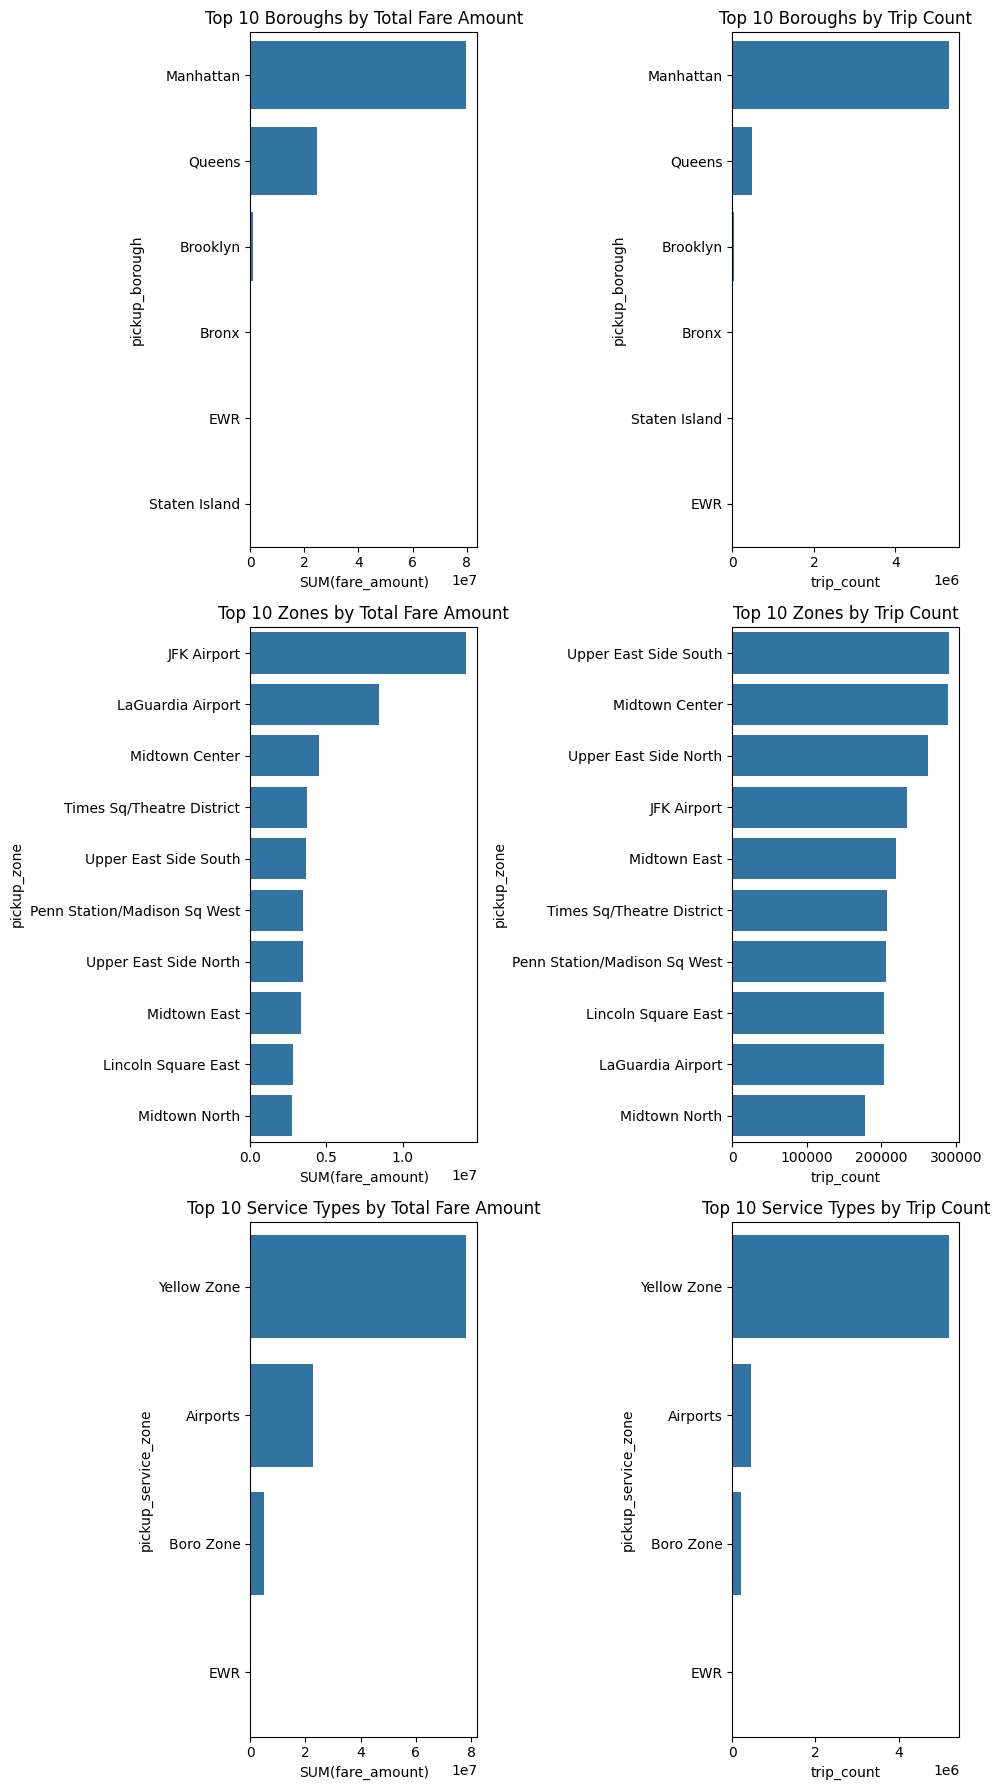

In [66]:
# Top borough, zone, and service type by average fare amount
borough_query = """
SELECT pickup_borough, SUM(fare_amount), COUNT(*) AS trip_count
FROM nyc_taxi.yellow_taxi_clean
GROUP BY pickup_borough
ORDER BY SUM(fare_amount) desc;
"""
zone_query = """
SELECT pickup_zone, SUM(fare_amount), COUNT(*) AS trip_count
FROM nyc_taxi.yellow_taxi_clean
GROUP BY pickup_zone
ORDER BY SUM(fare_amount) desc;
"""
service_type_query = """
SELECT pickup_service_zone, SUM(fare_amount), COUNT(*) AS trip_count
FROM nyc_taxi.yellow_taxi_clean
GROUP BY pickup_service_zone
ORDER BY SUM(fare_amount) desc;
"""
borough_data = pd.read_sql(borough_query, db_connection)
zone_data = pd.read_sql(zone_query, db_connection)
service_type_data = pd.read_sql(service_type_query, db_connection)

borough_fare = borough_data.sort_values(by='SUM(fare_amount)', ascending=False).head(10)
zone_fare = zone_data.sort_values(by='SUM(fare_amount)', ascending=False).head(10)
service_type_fare = service_type_data.sort_values(by='SUM(fare_amount)', ascending=False).head(10)

borough_count = borough_data.sort_values(by='trip_count', ascending=False).head(10)
zone_count = zone_data.sort_values(by='trip_count', ascending=False).head(10)
service_type_count = service_type_data.sort_values(by='trip_count', ascending=False).head(10)
# Visualizing the top boroughs, zones, and service types by total fare amount and trip count
fig, axes = plt.subplots(3, 2, figsize=(10, 18))
sns.barplot(data=borough_fare, x='SUM(fare_amount)', y='pickup_borough', ax=axes[0, 0])
axes[0,0].set_title('Top 10 Boroughs by Total Fare Amount')
sns.barplot(data=zone_fare, x='SUM(fare_amount)', y='pickup_zone', ax=axes[1, 0])
axes[1,0].set_title('Top 10 Zones by Total Fare Amount')
sns.barplot(data=service_type_fare, x='SUM(fare_amount)', y='pickup_service_zone', ax=axes[2,0])
axes[2,0].set_title('Top 10 Service Types by Total Fare Amount')

sns.barplot(data=borough_count, x='trip_count', y='pickup_borough', ax=axes[0, 1])
axes[0,1].set_title('Top 10 Boroughs by Trip Count')
sns.barplot(data=zone_count, x='trip_count', y='pickup_zone', ax=axes[1, 1])
axes[1,1].set_title('Top 10 Zones by Trip Count')
sns.barplot(data=service_type_count, x='trip_count', y='pickup_service_zone', ax=axes[2,1])
axes[2,1].set_title('Top 10 Service Types by Trip Count')   
plt.tight_layout()
plt.show()  

/var/folders/jc/zlyx5cfj47b4kf9kgt678kkc0000gn/T/ipykernel_11026/3680365470.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  hourly_fare = pd.read_sql(query, db_connection)


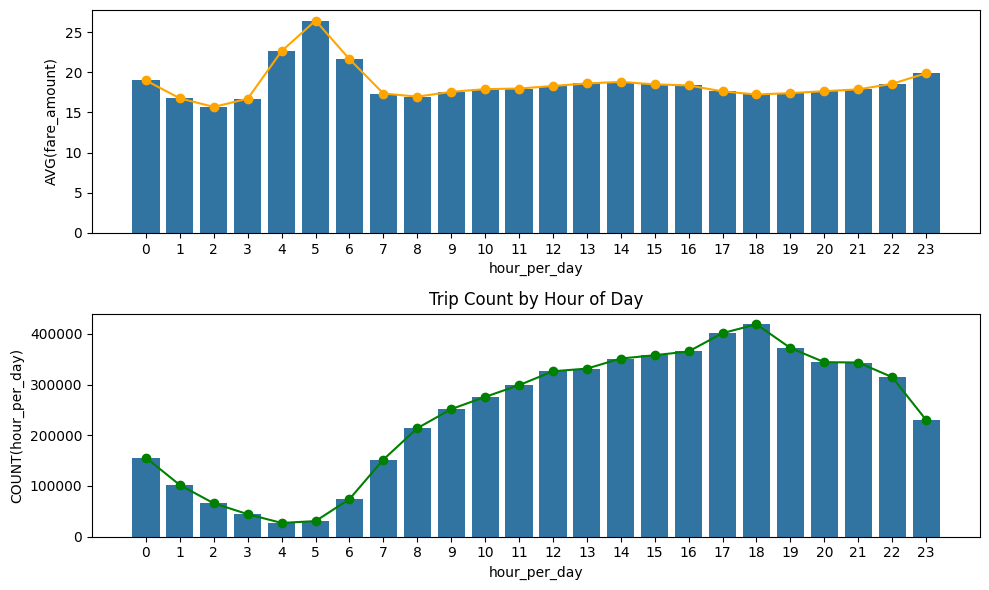

In [57]:
# hour of day vs average fare amount
query = """
SELECT hour_per_day,AVG(fare_amount), COUNT(hour_per_day) FROM (SELECT *, HOUR(tpep_pickup_datetime) as hour_per_day FROM nyc_taxi.yellow_taxi_clean) as hour_taxi 
GROUP BY hour_per_day;
"""
hourly_fare = pd.read_sql(query, db_connection)
fig, axes = plt.subplots(2, 1, figsize=(10, 6))
sns.barplot(data=hourly_fare, x='hour_per_day', y='AVG(fare_amount)', ax =axes[0])
axes[0].plot(hourly_fare['hour_per_day'], hourly_fare['AVG(fare_amount)'], marker='o', color='orange')
plt.title('Average Fare Amount by Hour of Day')

sns.barplot(data=hourly_fare, x='hour_per_day', y='COUNT(hour_per_day)', ax=axes[1])
axes[1].plot(hourly_fare['hour_per_day'], hourly_fare['COUNT(hour_per_day)'], marker='o', color='green')
plt.title('Trip Count by Hour of Day')
plt.tight_layout()

/var/folders/jc/zlyx5cfj47b4kf9kgt678kkc0000gn/T/ipykernel_11026/2901715361.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  condition_fare = pd.read_sql(condition_query, db_connection)


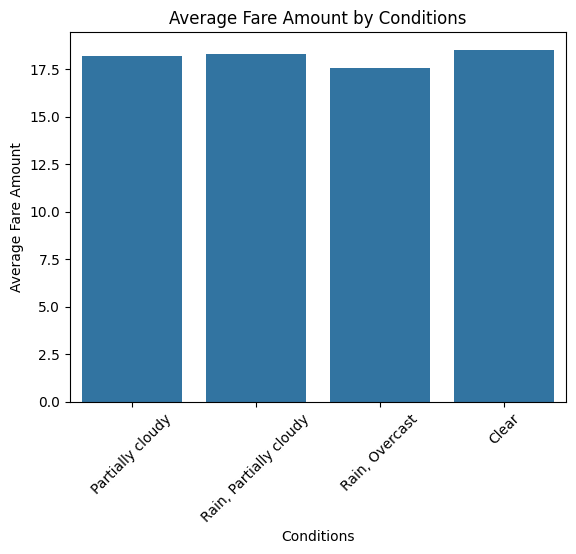

               conditions  AVG(fare_amount)  COUNT(conditions)
0        Partially cloudy         18.190181            2389394
2  Rain, Partially cloudy         18.293302            1409852
1          Rain, Overcast         17.583983            1319979
3                   Clear         18.518081             726770


In [59]:
# condition vs average fare amount
condition_query = """
SELECT conditions, AVG(fare_amount),COUNT(conditions) FROM nyc_taxi.yellow_taxi_clean GROUP BY conditions;
"""
condition_fare = pd.read_sql(condition_query, db_connection)
condition_fare = condition_fare.sort_values(by='COUNT(conditions)', ascending=False)
sns.barplot(data=condition_fare, x='conditions', y='AVG(fare_amount)')
plt.title('Average Fare Amount by Conditions')
plt.xlabel('Conditions')
plt.ylabel('Average Fare Amount')
plt.xticks(rotation=45)
plt.show()
print(condition_fare)